### Libraries and dependencies

In [173]:
import copy
import time
import torch
import random
import allensdk
import numpy as np
from scipy.stats import entropy
from tqdm import tqdm
from hmmlearn import hmm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import normalize
#from sklearn.decomposition import PCA
#import pomegranate
#from pomegranate.hmm import DenseHMM, SparseHMM
#from pomegranate.distributions import Poisson, Normal#, ZeroInflated
from skimage import data
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

In [448]:
output_dir = "C:/Users/Jerry/Downloads/vbn_s3_cache"
output_dir = Path(output_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

session_id = 1049273528 # Day one of this mice
# session_id = 1049514117 # Day two of this mice

#session_id = 1064644573 # Arbitrary pick

session = cache.get_ecephys_session(ecephys_session_id=session_id);
behavior_id = session.behavior_session_id;
behavior = cache.get_behavior_session(behavior_id);
sp = session.stimulus_presentations[session.stimulus_presentations['stimulus_block'] == 0]

c:\Users\Jerry\anaconda3\envs\allensdk\lib\site-packages\hdmf\spec\namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.8.0 because version 1.5.1 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
c:\Users\Jerry\anaconda3\envs\allensdk\lib\site-packages\hdmf\spec\namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
c:\Users\Jerry\anaconda3\envs\allensdk\lib\site-packages\hdmf\spec\namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.5.0 because version 0.2.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
c:\Users\Jerry\anaconda3\envs\allensdk\lib\site-packages\hdmf\spec\namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.8.0 because version 1.5.1 is al

In [447]:
units = session.get_units()
channels = session.get_channels()
spike_times = session.spike_times
unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)


unit_channels_filtered = unit_channels[(unit_channels.isi_violations < 0.5) &
                                      (unit_channels.presence_ratio > 0.9) &
                                      (unit_channels.amplitude_cutoff < 0.1) &
                                      (unit_channels.firing_rate > 0.1)]
units_vision = np.array(list(unit_channels_filtered[(unit_channels_filtered['structure_acronym']=='VISp') |
                                                   (unit_channels_filtered['structure_acronym']=='VISpm') |
                                                   (unit_channels_filtered['structure_acronym']=='VISrl') |
                                                   (unit_channels_filtered['structure_acronym']=='VISl') |
                                                   (unit_channels_filtered['structure_acronym']=='VISam') |
                                                   (unit_channels_filtered['structure_acronym']=='VISal')
                                                   ].index))
unit_channels_indices = units_vision
print(len(unit_channels_indices))

264


In [ ]:
'VISp', 'VISpm', 'VISrl', 'VISl', 'VISam', 'VISal'

### Helper Functions

In [449]:
# Obtain binned neuron spikings
# Start, stop are in seconds and bin_size is in ms
def getX(start, stop, bin_size):
    if (stop < 0 or start < 0):
        return -1
    time = stop - start
    bin_count = int(time * 1000 / bin_size)
    X = np.zeros(bin_count)
    for unit in tqdm(unit_channels_indices):
        # Dividing epochs
        raw_spikes = spike_times[unit]
        bins = np.linspace(start,stop,num=bin_count+1)
        x_1 = np.histogram(raw_spikes, bins=bins)[0].tolist()
        #x_1 = np.array(stats.zscore(x_1))
        X = np.vstack((X, x_1))
    X = np.delete(X, 0, 0)
    return X

# Plot a raster plot for binned neuron spikings
def raster(X):
    plt.figure(figsize=(20,10))
    raster_pos = {}
    for idx, row in enumerate(X):
        raster_pos[idx] = np.where(row==1)[0]
    raster_pos = raster_pos.values()
    plt.eventplot(raster_pos,linelengths=1,linewidths=1);

# Transform counts in each bin to only 1, randomly allocate 1 when no activities
def one_per_bin(X):
    X_1 = X.astype(bool).astype(int)
    for idx, bin in enumerate(X_1):
        if (np.sum(bin) > 1):
            new_bin = np.zeros(len(bin))
            random_neuron = np.random.choice(np.arange(0,len(bin)),1)
            new_bin[random_neuron] = 1
            X_1[idx] = new_bin
    return X_1

# Not used
def between_stimulus(session, trial_idx, bin_size, window):
    # Getting all the trials
    trials = session.trials
    # Only the ones that changed
    trials_change = trials[trials['is_change']]
    trial = trials_change.iloc[trial_idx]
    change_time = trial['change_time_no_display_delay']
    change_from = trial['initial_image_name']
    change_to = trial['change_image_name']

    # start and end in seconds
    start = change_time - window
    end = change_time + window
    X = getX(start, end, bin_size)
    x_axis = np.arange(- window * 1000, window * 1000+1, step=int(bin_size * 5))
    ticks = np.arange(0, 2 * window * 1000 + 1, step = int(bin_size * 5))
    return X.T, [change_from, change_to], x_axis, ticks

# Testing function to manually check prediction and stimulus
def display_stim(session):
    dictionary = {}
    trials = session.trials
    trials_idx = trials[(trials['start_time']>50) & (trials['stop_time']<650)].index
    for idx in trials_idx:
        trial = session.trials.loc[idx]
        change_from = trial['initial_image_name']
        change_to = trial['change_image_name']
        change_at = trial['change_time_no_display_delay']
        trial_start = trial['start_time']
        trial_end = trial['stop_time']
        if (change_from not in dictionary):
            dictionary[change_from] = 0
        dictionary[change_from] += 1
        if (change_to not in dictionary):
            dictionary[change_to] = 0
        dictionary[change_to] += 1
        #print('start: {}({}) |{}| {}({})'.format(change_from, trial_start, change_at, change_to,trial_end))
        if (len(list(dictionary.keys()))==8):
            continue
            #break
    return dictionary

# Obtaining histograms that shows the stimulus distribution for each hidden state
# Not used, use states_per_img() instead
def get_states_histogram(start, end, bin_size, predictions):
    sp = session.stimulus_presentations[session.stimulus_presentations['stimulus_block']==0]
    stimulus_presentation_id = 0
    is_change = sp.loc[0]['is_change']
    counts_unchanged = {}
    counts_hit = {}
    counts_miss = {}
    
    stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
    stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
    unique_stimuli = np.append(np.unique(sp['image_name']), "gray")
    unique_preds = np.unique(predictions)

    all_states = {}
    for pred in unique_preds:
        all_states[pred] = 0
    for stimulus in unique_stimuli:
        counts_unchanged[stimulus] = copy.deepcopy(all_states)
    counts_hit = copy.deepcopy(counts_unchanged)
    counts_miss = copy.deepcopy(counts_unchanged)
        
    for idx, pred in enumerate(predictions):
        bin_start_time = float(start + (bin_size / 1000) * idx)
        # Bin before stimulus: gray screen
        if (bin_start_time < stimulus_start_time):
            stimulus_name = "gray"
        # Bin after stimulus: gray screen, move to the next stimulus
        elif (bin_start_time > stimulus_end_time):
            stimulus_presentation_id += 1
            stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
            stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
            is_change = sp.loc[stimulus_presentation_id]['is_change']
            if (bin_start_time < stimulus_start_time):
                stimulus_name = "gray"
            else:
                stimulus_name = sp.loc[stimulus_presentation_id]['image_name']
        else:
            stimulus_name = sp.loc[stimulus_presentation_id]['image_name']
            
        if not is_change:
            counts_unchanged[stimulus_name][pred] += 1
        else:
            hit = sp.loc[stimulus_presentation_id]['rewarded']
            if hit:
                counts_hit[stimulus_name][pred] += 1
            else:
                counts_miss[stimulus_name][pred] += 1
    return counts_unchanged, counts_hit, counts_miss

# Assign hidden states to each image
def states_per_img_no_first(start, end, bin_size, predictions):
    sp = session.stimulus_presentations[session.stimulus_presentations['stimulus_block'] == 0]
    # dictionary for each pred
    unique_preds = np.unique(predictions)
    states = {str(state): 0 for state in unique_preds}
    # dictionary for unchange, hit, miss
    unique_stimuli = np.unique(sp['image_name'])
    unchanged = {stimulus: copy.deepcopy(states) for stimulus in unique_stimuli}
    gray = copy.deepcopy(states)
    hit = copy.deepcopy(unchanged)
    miss = copy.deepcopy(unchanged)
    # The initial stimulus info
    stimulus_presentation_id=sp[sp['start_time'] <= start].index[-1]
    stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
    stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
    first_hidden_state = True # Just trying - not recording the first hidden state for each stimulus 
    for idx, pred in enumerate(predictions):
        bin_start_time = float(start + (bin_size / 1000) * idx)
        if bin_start_time > end:
            break
        stimulus_name = sp.loc[stimulus_presentation_id]['image_name']
        is_change = sp.loc[stimulus_presentation_id]['is_change']
        is_hit = sp.loc[stimulus_presentation_id]['rewarded']
        # Bin before stimulus: gray screen
        if (bin_start_time < stimulus_start_time):
            if not first_hidden_state:
                gray[str(pred)] += 1
                if (bin_start_time + bin_size / 1000 > stimulus_start_time): # Next hidden state will be the first for an img
                    #print("next: ", bin_start_time + bin_size / 1000, stimulus_start_time)
                    first_hidden_state = True
            else:
                first_hidden_state = False # Skipping
            continue
        # Bin after stimulus: gray screen, move to the next stimulus
        elif (bin_start_time > stimulus_end_time):
            #print("after: ", bin_start_time, stimulus_end_time)
            stimulus_presentation_id += 1
            stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
            stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
            first_hidden_state = False
            #gray[str(pred)] += 1 # Skipped because this is the first hidden state in gray screen
            continue
        else:
            if first_hidden_state:
                #print("img: ", bin_start_time, stimulus_start_time)
                first_hidden_state = False
                continue
            if not is_change:
                unchanged[stimulus_name][str(pred)] += 1
            else:
                if is_hit:
                    hit[stimulus_name][str(pred)] += 1
                else:
                    miss[stimulus_name][str(pred)] += 1
    return unchanged, hit, miss, gray
    

def states_per_img(start, end, bin_size, predictions):
    sp = session.stimulus_presentations[session.stimulus_presentations['stimulus_block'] == 0]
    # dictionary for each pred
    unique_preds = np.unique(predictions)
    states = {str(state): 0 for state in unique_preds}
    # dictionary for unchange, hit, miss
    unique_stimuli = np.unique(sp['image_name'])
    unchanged = {stimulus: copy.deepcopy(states) for stimulus in unique_stimuli}
    gray = copy.deepcopy(states)
    hit = copy.deepcopy(unchanged)
    miss = copy.deepcopy(unchanged)
    # The initial stimulus info
    stimulus_presentation_id=sp[sp['start_time'] <= start].index[-1]
    stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
    stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
    for idx, pred in enumerate(predictions):
        bin_start_time = float(start + (bin_size / 1000) * idx)
        if bin_start_time > end:
            break
        stimulus_name = sp.loc[stimulus_presentation_id]['image_name']
        is_change = sp.loc[stimulus_presentation_id]['is_change']
        is_hit = sp.loc[stimulus_presentation_id]['rewarded']
        # Bin before stimulus: gray screen
        if (bin_start_time < stimulus_start_time):
            gray[str(pred)] += 1
            continue
        # Bin after stimulus: gray screen, move to the next stimulus
        elif (bin_start_time > stimulus_end_time):
            #print("after: ", bin_start_time, stimulus_end_time)
            stimulus_presentation_id += 1
            stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
            stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
            gray[str(pred)] += 1 # Skipped because this is the first hidden state in gray screen
            continue
        else:
            if not is_change:
                unchanged[stimulus_name][str(pred)] += 1
            else:
                if is_hit:
                    hit[stimulus_name][str(pred)] += 1
                else:
                    miss[stimulus_name][str(pred)] += 1
    return unchanged, hit, miss, gray
    
# Shows the hidden state distribution for each image stimulus and gray screen
def stimulus_state_dist(unchanged, hit, miss, gray):
    fig, axs = plt.subplots(len(unchanged)+1,3, figsize=(15,32))
    # Stimulus -> States
    for idx, each in enumerate(unchanged.keys()):
        states = list(unchanged[each].keys())
        unchanged_val = list(unchanged[each].values())
        unchanged_val = unchanged_val / np.sum(unchanged_val)
        axs[idx][0].bar(states, unchanged_val)
        axs[idx][0].set_title(str(each))
        axs[idx][0].set_yticks(np.arange(0,1.2,0.2))
        if (each == 'omitted'):
            continue

        hit_val = list(hit[each].values())
        hit_val = hit_val / np.sum(hit_val)
        axs[idx][1].bar(states, hit_val)
        axs[idx][1].set_title('hit')
        axs[idx][1].set_yticks(np.arange(0,1.2,0.2))

        miss_val = list(miss[each].values())
        miss_val = miss_val / np.sum(miss_val)
        axs[idx][2].bar(states, miss_val)
        axs[idx][2].set_title('miss')
        axs[idx][2].set_yticks(np.arange(0,1.2,0.2))
    states = list(gray.keys())
    gray_val = list(gray.values())
    gray_val = gray_val / np.sum(gray_val)
    axs[-1][0].bar(states, gray_val)
    axs[-1][0].set_title('gray')
    axs[-1][0].set_yticks(np.arange(0,1.2,0.2))

# Find and plot Euclidean distance across unchanged, hit, and miss trials
def stimulus_state_diff(unchanged, hit, miss, gray):
    # For each hidden state
    u = np.zeros(len(unchanged.keys()))
    h = copy.deepcopy(u)
    m = copy.deepcopy(u)
    gh = copy.deepcopy(u)
    gm = copy.deepcopy(u)
    gd = copy.deepcopy(u)
    hm = copy.deepcopy(u)
    for idx, stimulus in enumerate(unchanged.keys()):
        # Preprocess into ratios
        unchanged_each = list(unchanged[stimulus].values())
        unchanged_total = np.sum(unchanged_each) if np.sum(unchanged_each) > 0 else 1e-10
        unchanged_ratio = np.array(unchanged_each)/unchanged_total    
        hit_each = list(hit[stimulus].values())
        hit_total = np.sum(hit_each) if np.sum(hit_each) > 0 else 1e-10
        hit_ratio = np.array(hit_each)/hit_total
        miss_each = list(miss[stimulus].values())
        miss_total = np.sum(miss_each) if np.sum(miss_each) > 0 else 1e-10
        miss_ratio = np.array(miss_each)/miss_total
        gray_each = list(gray.values())
        gray_total = np.sum(gray_each) if np.sum(gray_each) > 0 else 1e-10
        gray_ratio = np.array(gray_each)/gray_total
        # Distance of baseline
        u[idx] = np.linalg.norm(unchanged_ratio)
        # Distance of hit w/ unchanged
        h[idx] = np.linalg.norm(unchanged_ratio - hit_ratio)
        # Distance of miss w/ unchanged
        m[idx] = np.linalg.norm(unchanged_ratio - miss_ratio)
        # Distance of hit w/ gray
        # gh[idx] = np.linalg.norm(gray_ratio - hit_ratio)
        # Distance of miss w/ gray
        # gm[idx] = np.linalg.norm(gray_ratio - miss_ratio)
        # Bar plot of difference between the two
        # gd[idx] = np.abs(gh[idx] - gm[idx])
        hm[idx] = np.linalg.norm(hit_ratio - miss_ratio)
        
    plt.figure(figsize=(20,10))
    #plt.plot(u, label='baseline')
    plt.plot(h, label='hit')
    plt.plot(m, label='miss')
#    plt.plot(gh, label='hit w/ gray')
#    plt.plot(gm, label='miss w/ gray')
    plt.plot(hm, label='hit w/ miss')
    plt.bar(np.arange(0,len(unchanged.keys())), gd, alpha=0.3)
    plt.xticks(ticks=np.arange(0,len(unchanged.keys())), labels=[str(each) for each in list(unchanged.keys())], label="diff between hit w/ gray and miss w/ gray")
    plt.legend()

# Get entropy using sklearn.stats.entropy with base 2, input a nested dictionary
def get_entropy(d):
    imgs = list(d.keys())
    try:
        imgs.remove('omitted')
    except:
        print("No Omitted")
    entropies = np.zeros(len(imgs))
    for idx, img in enumerate(imgs):
        values = np.array(list(d[img].values()))
        if np.sum(values) == 0:
            entropies[idx] = 5
            continue
        entropies[idx] = entropy(values, base=2)
    return entropies

def get_entropy_gray(gray):
    return entropy(np.array(list(gray.values())), base=2)

### Model Selection and Cross-validation

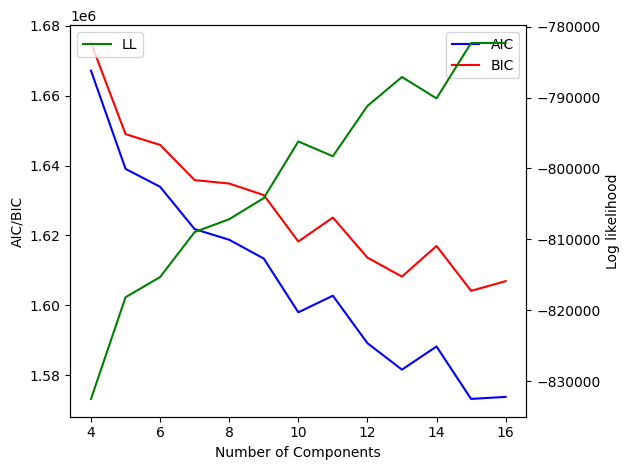

In [ ]:
X_train = getX(50,3550,50).T
# train on the entire dataset
iters = 1
ns = np.arange(4,404,100)
aic = np.zeros([len(ns),iters])
bic = np.zeros([len(ns),iters])
ll =  np.zeros([len(ns),iters])
for idx, n in tqdm(enumerate(ns)):
    for i in range(iters):
        model = hmm.PoissonHMM(n_components=n, n_iter=1000, verbose=True, tol=10)
        model.fit(X_train)
        aic[idx][i] = model.aic(X_train)
        bic[idx][i] = model.bic(X_train)
        ll[idx][i] = model.score(X_train)
fig, ax = plt.subplots()
ln1 = ax.plot(ns, np.mean(aic,axis=1), color='blue', label="AIC")
ln2 = ax.plot(ns, np.mean(bic,axis=1), color='red', label="BIC")
ax.legend()
ax2 = ax.twinx()
ln3 = ax2.plot(ns, np.mean(ll,axis=1), color='green', label="LL")
ax.set_ylabel("AIC/BIC")
ax2.set_ylabel("Log likelihood")
ax.set_xlabel("Number of Components")
ax2.legend()
fig.tight_layout()
plt.show()

### To make sure HMM works

In [ ]:
def generate_distinct_colors(n):
    colors = plt.cm.get_cmap('turbo', n)
    return [colors(i)[:3] for i in range(n)]
def visualize_prediction(start, end, target_start, target_end, bin_size, lambdas):
    bin_size /= 1000 # ms to s
    # Getting the closest time bins based on desired start and end time
    target_start_idx = int((target_start - start) / bin_size)
    target_start = start + bin_size * target_start_idx
    target_end_idx = int((target_end - start) / bin_size)
    target_end = start + bin_size * target_end_idx
    # Get the corresponding lambdas
    truncated_lambdas = lambdas[target_start_idx:target_end_idx]
    # Plot the states (lambdas)
    plt.figure(figsize=(40,20))
    plt.plot(np.arange(target_start, target_end-1e-5, bin_size), truncated_lambdas, ".-", mfc="orange");
    # Obtain the corresponding stimuli
    start_idx = list(sp[sp['start_time']>target_start].index)[0]
    end_idx = list(sp[sp['start_time']<target_end].index)[-1]
    unique_stimuli = np.unique(sp.loc[start_idx:end_idx]['image_name'])
    color = generate_distinct_colors(len(unique_stimuli))
    colors = {unique_stimuli[idx]: color[idx] for idx, each in enumerate(unique_stimuli)}
    labeled = {each: False for each in unique_stimuli} # Label stimulus color just once
    # Color based on each stimulus
    for i in range(start_idx, end_idx+1, 1):
        start_time = sp.loc[i]['start_time']
        end_time = sp.loc[i]['end_time']
        image_name = sp.loc[i]['image_name']
        if not labeled[image_name]:
            plt.axvspan(start_time, end_time, color=colors[image_name], alpha=0.3, label=image_name)
            labeled[image_name] = True
        else:
            plt.axvspan(start_time, end_time, color=colors[image_name], alpha=0.3)
    plt.legend()

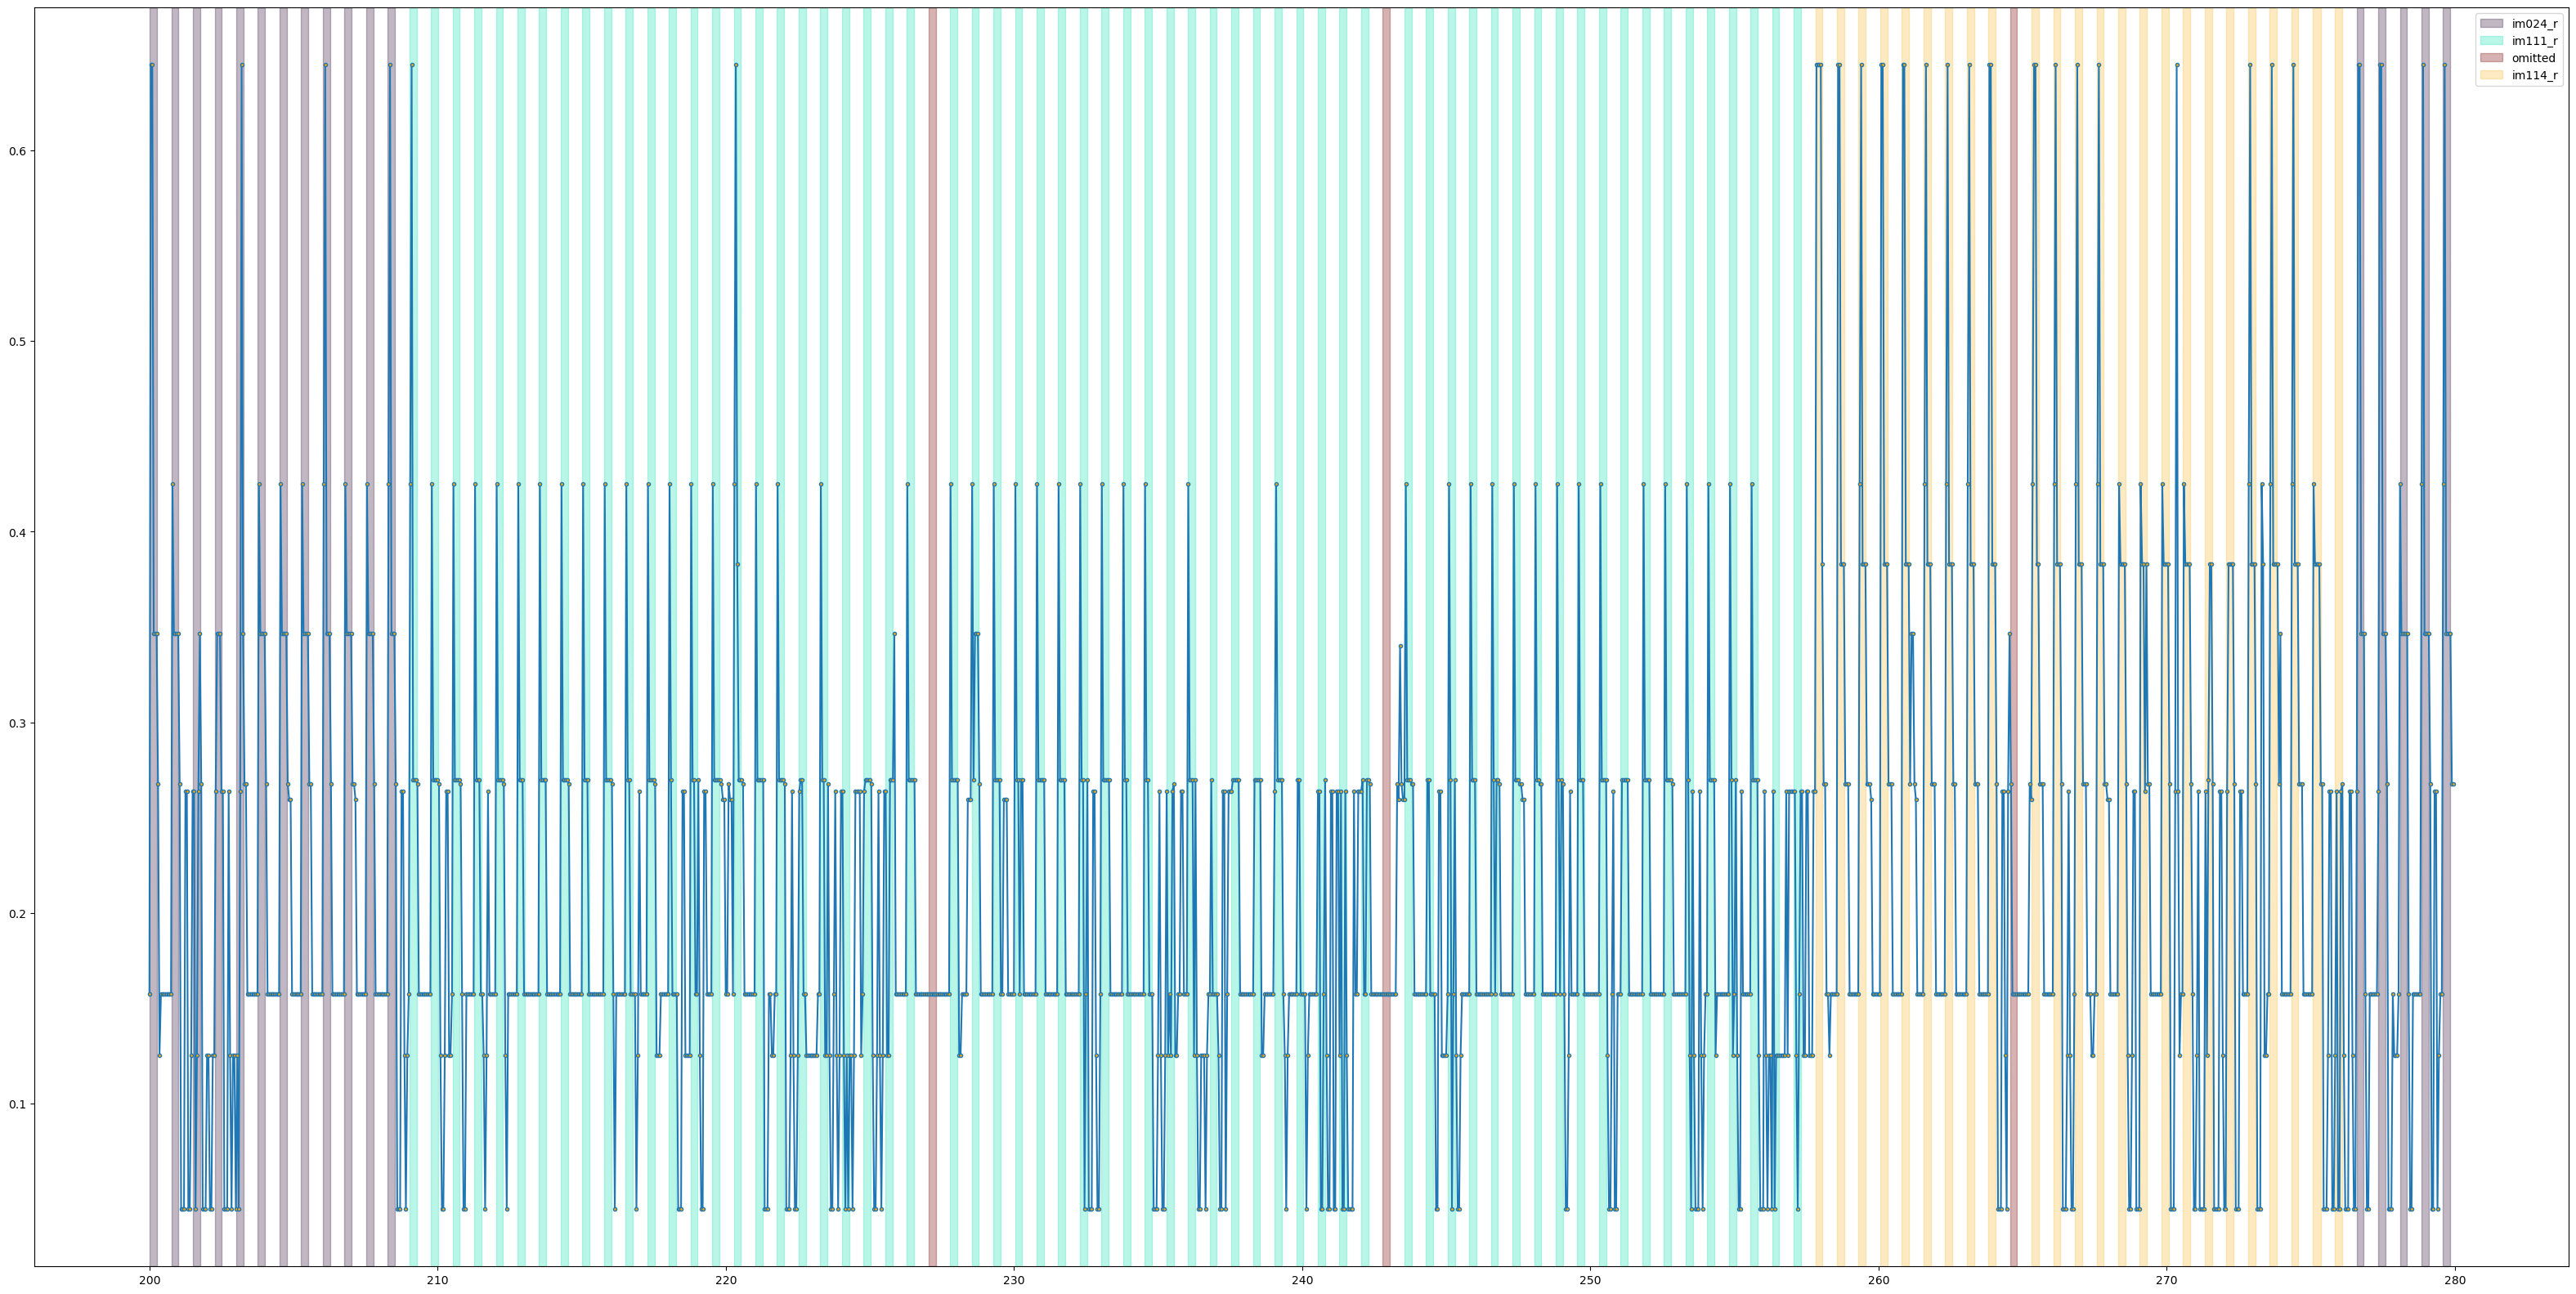

In [ ]:
lambdas = np.mean(model.lambdas_[preds], axis = 1)
bin_size = 50
visualize_prediction(start_time, end_time, 200, 280, bin_size, lambdas)

K-fold CV with entropy

In [363]:
n_fold = 5
bin_num = np.arange(4,13)
entropies = {'u':np.zeros(8), 'h':np.zeros(8), 'm':np.zeros(8), 'g':0}
total_entropy = {n: copy.deepcopy(entropies) for n in bin_num}
start_time = sp.iloc[0]['start_time']
end_time = sp.iloc[-1]['end_time']
bin_size = 50
X = getX(start_time,end_time,bin_size).T
for n in tqdm(bin_num):
    frac_time = (end_time - start_time) / n_fold
    frac_state = int(len(X) / 10)
    u = np.zeros(8)
    h = np.zeros(8)
    m = np.zeros(8)
    g = 0
    for i in range(n_fold-1):
        X_train = X[0:(i+1)*frac_state]
        X_test = X[(i+1)*frac_state:(i+2)*frac_state]
        train_start = start_time
        train_end = start_time + (i+1) * frac_time
        test_start = train_end
        test_end = test_start + frac_time
        model = hmm.PoissonHMM(n_components=n, n_iter=1000, tol=100, verbose=False)
        model.fit(X_train)
        preds = model.predict(X_test)
        unchanged, hit, miss, gray = states_per_img_no_first(test_start, test_end, bin_size, preds)

        u += get_entropy(unchanged)
        h += get_entropy(hit)
        m += get_entropy(miss)
        g += get_entropy_gray(gray)

    u = u / n_fold
    h = h / n_fold
    m = m / n_fold
    g = g / n_fold
    total_entropy[n]['u'] = u
    print(u)
    total_entropy[n]['h'] = h
    print(h)
    total_entropy[n]['m'] = m
    print(m)
    total_entropy[n]['g'] = g
    print(g)
    print("----------------------")
        

  0%|          | 0/293 [00:00<?, ?it/s]

 11%|█         | 1/9 [01:58<15:45, 118.25s/it]

[0.83701686 0.89799999 0.96721975 0.91732761 0.85762376 0.7159417
 0.80036306 0.89605703]
[0.59694675 0.65637256 1.57796165 1.36093417 0.74338344 0.69226011
 0.44338344 0.60831258]
[3.16225562 3.16225562 2.36225562 0.48676687 2.2        3.2
 0.16225562 1.1908868 ]
1.3134821340823546
----------------------


 22%|██▏       | 2/9 [04:31<16:13, 139.01s/it]

[1.01213776 1.213607   1.29682483 1.23856576 1.13455708 0.97799928
 1.04821335 1.06895838]
[0.68463216 0.91634083 1.64633253 1.33593417 0.6898407  0.78064568
 0.60563906 0.47096851]
[3.         3.16225562 2.28112781 0.79652586 2.2        3.2
 0.45451573 1.47451125]
1.4917990265855576
----------------------


 33%|███▎      | 3/9 [09:37<21:31, 215.32s/it]

[1.1156827  1.25421308 1.32741918 1.39086861 1.27104491 1.15755568
 1.05211981 1.20071093]
[0.82377409 0.6398407  1.5700783  1.42714768 0.56225562 0.85727462
 0.55209633 0.53676687]
[3.         3.16225562 2.52451125 0.55209633 2.16225562 3.1908868
 0.71839005 1.61225562]
1.7216386134773423
----------------------


 44%|████▍     | 4/9 [12:52<17:15, 207.17s/it]

[1.08939238 1.18472748 1.34310591 1.43879947 1.37183354 1.16055755
 1.08587595 1.21320742]
[0.95885092 0.6398407  1.75073406 1.36507516 0.56225562 0.92725787
 0.60563906 0.51742578]
[3.         3.16225562 2.47451125 0.87451125 2.2        3.31225562
 0.58064568 1.75563906]
1.7968876431803722
----------------------


 56%|█████▌    | 5/9 [18:05<16:20, 245.20s/it]

[1.18477559 1.33531862 1.53806144 1.48776066 1.32509412 1.22075457
 1.1354622  1.31433596]
[0.99967417 0.8398407  1.7964098  1.5231898  0.85563906 1.02725787
 0.60563906 0.6796814 ]
[3.16225562 3.16225562 2.52451125 0.94338344 2.         3.25975899
 0.5908868  1.70563906]
1.9840012266725278
----------------------


 67%|██████▋   | 6/9 [24:17<14:25, 288.45s/it]

[1.41544639 1.56231232 1.77161497 1.64604046 1.52818375 1.42308952
 1.36506004 1.52359974]
[1.27280109 0.82841591 1.87672919 1.63475899 0.64338344 1.02725787
 0.93427024 0.82096851]
[3.         3.16225562 2.43112781 0.82451125 2.2        3.3
 0.64967417 1.4       ]
2.127847374879466
----------------------


 78%|███████▊  | 7/9 [31:10<10:58, 329.11s/it]

[1.4496989  1.56842305 1.79731988 1.62278569 1.53690028 1.53887327
 1.37091218 1.54383435]
[1.26145951 0.89188854 1.7964098  1.53725562 0.63112781 1.15838568
 0.60563906 0.86847188]
[3.         3.16225562 2.59338344 0.90563906 2.16225562 3.25975899
 0.5627981  1.31225562]
2.113406876829736
----------------------


 89%|████████▉ | 8/9 [38:12<05:58, 358.59s/it]

[1.57712753 1.7614556  1.99841561 1.76620407 1.76409198 1.67005682
 1.62789657 1.76958075]
[1.2844169  0.92630359 2.02726192 1.53725562 1.03676687 1.25021526
 0.73322414 1.09338344]
[3.2        3.16225562 2.48112781 0.72451125 2.16225562 3.3
 0.99558896 1.68676687]
2.262091342284827
----------------------


100%|██████████| 9/9 [45:11<00:00, 301.27s/it]

[1.43235296 1.52433123 1.83870155 1.68627508 1.57228584 1.5076307
 1.47897783 1.58289985]
[1.15650599 1.00379409 1.7964098  1.53725562 0.63112781 1.03951349
 0.76789469 0.97201461]
[3.         3.16225562 2.5        1.06225562 2.3        3.38112781
 0.60817042 1.31225562]
2.2979818232497373
----------------------


In [415]:
trials = list(total_entropy.keys())
u_total = np.zeros(len(trials))
h_total = np.zeros(len(trials))
m_total = np.zeros(len(trials))
g_total = np.zeros(len(trials))
for idx, trial in enumerate(trials):
    u_total[idx] = np.mean(total_entropy[trial]['u']) / np.log2(trial)
    h_total[idx] = np.mean(total_entropy[trial]['h']) / np.log2(trial) 
    m_total[idx] = np.mean(total_entropy[trial]['m']) / np.log2(trial)
    g_total[idx] = total_entropy[trial]['g'] / np.log2(trial)

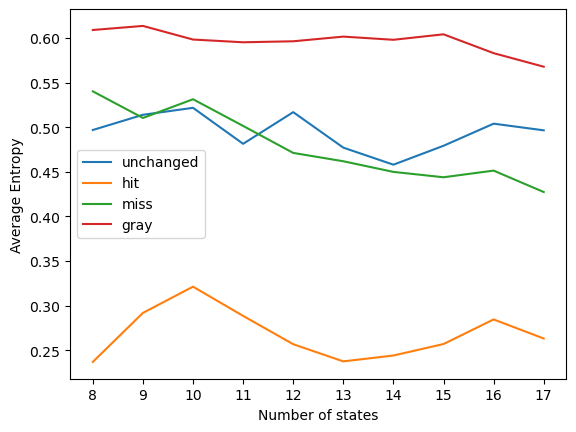

In [416]:
plt.plot(u_total, label='unchanged')
plt.plot(h_total, label='hit')
plt.plot(m_total, label='miss')
plt.plot(g_total, label='gray')
plt.xticks(ticks=np.arange(0,10),labels=np.arange(8,18))
plt.xlabel("Number of states")
plt.ylabel("Average Entropy")
plt.legend();

In [413]:
n_fold = 3
bin_num = np.arange(8,18)
entropies = {'u':np.zeros(8), 'h':np.zeros(8), 'm':np.zeros(8), 'g':0}
total_entropy = {n: copy.deepcopy(entropies) for n in bin_num}
start_time = sp.iloc[0]['start_time']
end_time = sp.iloc[-1]['end_time']
bin_size = 50
X = getX(start_time,end_time,bin_size).T
for n in tqdm(bin_num):
    frac_time = (end_time - start_time) / n_fold
    frac_state = int(len(X) / 10)
    u = np.zeros(8)
    h = np.zeros(8)
    m = np.zeros(8)
    g = 0
    for i in tqdm(range(n_fold-1)):
        X_train = X[0:(i+1)*frac_state]
        X_test = X[(i+1)*frac_state:(i+2)*frac_state]
        train_start = start_time
        train_end = start_time + (i+1) * frac_time
        test_start = train_end
        test_end = test_start + frac_time
        model = hmm.PoissonHMM(n_components=n, n_iter=1000, tol=1000, verbose=False)
        model.fit(X_train)
        preds = model.predict(X_test)
        unchanged, hit, miss, gray = states_per_img_no_first(test_start, test_end, bin_size, preds)
        u += get_entropy(unchanged)
        h += get_entropy(hit)
        m += get_entropy(miss)
        g += get_entropy_gray(gray)

    u = u / n_fold
    h = h / n_fold
    m = m / n_fold
    g = g / n_fold
    total_entropy[n]['u'] = u
    print(u)
    total_entropy[n]['h'] = h
    print(h)
    total_entropy[n]['m'] = m
    print(m)
    total_entropy[n]['g'] = g
    print(g)
    print("----------------------")
        

  0%|          | 0/293 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:49<07:25, 49.53s/it]

[1.54895895 1.46404536 1.53255551 1.65197191 1.32879727 1.41528891
 1.38219244 1.6019189 ]
[0.54085208 0.65578646 1.11846285 0.60375937 0.88888889 0.33333333
 0.63521302 0.91003312]
[1.66666667 2.16666667 0.33333333 0.70583082 2.16666667 1.66666667
 0.92689071 3.33333333]
1.8270311340846044
----------------------


 20%|██        | 2/10 [01:39<06:39, 49.98s/it]

[1.68818268 1.66084827 1.694548   1.65778594 1.38405249 1.67395161
 1.56452627 1.71013757]
[1.13521302 0.91003312 0.80609861 1.         1.09471971 0.5
 1.05187969 0.90355853]
[1.66666667 1.93709271 0.54085208 0.59471971 2.16666667 1.66666667
 1.03800182 3.33333333]
1.9450089700539355
----------------------


 30%|███       | 3/10 [02:39<06:21, 54.56s/it]

[1.83779742 1.73390074 1.82366886 1.77179881 1.54670562 1.67772264
 1.70414396 1.77036946]
[0.85375937 1.17392741 1.28512951 0.96854635 1.18486172 0.81814467
 0.93709271 1.31679193]
[2.16666667 2.16666667 0.54085208 0.78512951 2.16666667 2.
 0.9626395  3.33333333]
1.9875607398765844
----------------------


 40%|████      | 4/10 [03:37<05:34, 55.78s/it]

[1.76897784 1.7353862  1.66687592 1.83984673 1.34545474 1.48891676
 1.6824473  1.79609208]
[0.70335769 0.91639024 1.31694193 0.96854635 1.20860486 0.68118815
 1.08333333 1.10685905]
[1.66666667 2.16666667 0.54085208 0.62930617 2.33333333 2.
 1.20860486 3.33333333]
2.0592456122345966
----------------------


 50%|█████     | 5/10 [04:55<05:18, 63.77s/it]

[1.95084993 1.8971384  1.97622377 1.98935546 1.73662138 1.77743883
 1.67664976 1.82106311]
[0.77042604 0.99710489 1.11111111 0.83333333 1.25054306 0.96854635
 0.651478   0.78199524]
[1.66666667 2.16666667 0.5        0.89624063 2.16666667 1.66666667
 1.11846285 3.33333333]
2.137912793264991
----------------------


 60%|██████    | 6/10 [06:14<04:35, 68.89s/it]

[1.88034912 1.72020942 1.84729383 1.93586356 1.4258293  1.80936782
 1.72230152 1.78363464]
[0.77042604 0.83266615 1.22222222 0.96854635 1.05555556 0.33333333
 0.90563906 0.94314467]
[1.66666667 2.16666667 0.60375937 0.89624063 1.93709271 1.93709271
 1.13208021 3.33333333]
2.226200439110331
----------------------


 70%|███████   | 7/10 [07:28<03:32, 70.79s/it]

[1.91658627 1.76390215 1.79513747 1.89049047 1.47186584 1.78508477
 1.55312787 1.77498451]
[0.85375937 0.64039323 1.11846285 1.16666667 1.20860486 0.51452148
 0.79085208 1.14247376]
[1.66666667 2.16666667 0.77042604 0.84068507 2.16666667 1.66666667
 1.09355738 3.33333333]
2.2769494330576134
----------------------


 80%|████████  | 8/10 [09:10<02:40, 80.43s/it]

[2.00248808 1.81875302 1.97866233 2.05100976 1.56365771 1.80550939
 1.810243   1.94814401]
[0.93709271 1.0515461  1.36165417 1.13521302 1.         0.33333333
 1.13521302 1.07835769]
[1.66666667 2.16666667 0.93709271 0.72957396 2.16666667 1.66666667
 1.20860486 3.33333333]
2.3604517477947966
----------------------


 90%|█████████ | 9/10 [10:48<01:26, 86.20s/it]

[2.13548568 2.10631501 2.16674035 2.13992517 1.59569366 2.0061594
 1.95515326 2.02294276]
[0.93709271 1.17741784 1.28512951 1.08333333 1.28512951 0.85375937
 1.08333333 1.40060625]
[2.         2.16666667 0.54085208 0.97276528 2.16666667 2.
 1.26416042 3.33333333]
2.332184768418917
----------------------


100%|██████████| 10/10 [12:50<00:00, 77.03s/it]

[2.19448212 2.13200487 2.16360067 2.23337522 1.67876423 1.84470252
 1.95748571 2.03265885]
[0.62418542 1.26626498 1.31694193 1.         1.07652465 0.51452148
 1.41666667 1.39126498]
[1.93709271 1.93709271 0.54085208 0.97276528 2.16666667 1.93709271
 1.15027526 3.33333333]
2.321109732021276
----------------------


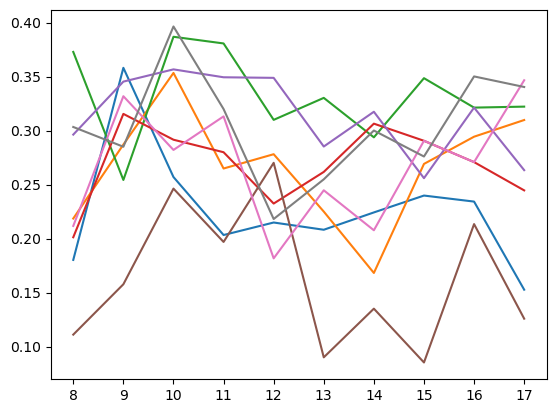

In [414]:
trials = list(total_entropy.keys())
u_total = np.zeros(len(imgs[0:-1]))
h_total = np.zeros(len(imgs[0:-1]))
m_total = np.zeros(len(imgs[0:-1]))
for idx, trial in enumerate(trials):
    u_total = np.vstack((u_total, np.array(list(total_entropy.values()))[idx]['u'] / np.log2(trial)))
    h_total = np.vstack((h_total, np.array(list(total_entropy.values()))[idx]['h']/ np.log2(trial)))
    m_total = np.vstack((m_total, np.array(list(total_entropy.values()))[idx]['m']/ np.log2(trial)))
    g_total[idx] = total_entropy[trial]['g'] / trial
u_total = np.delete(u_total, 0,0)
h_total = np.delete(h_total, 0,0)
m_total = np.delete(m_total, 0,0)
#plt.plot(u_total)
plt.plot(h_total)
#plt.plot(u_total)
plt.xticks(ticks=np.arange(0,10), labels=np.arange(8,18))
#plt.plot(u_total)
"""plt.plot(u_total, label='unchanged')
plt.plot(h_total, label='hit')
plt.plot(m_total, label='miss')
plt.plot(g_total, label='gray')
plt.xticks(ticks=np.arange(0,10),labels=np.arange(8,18))
plt.xlabel("Number of states")
plt.ylabel("Average Entropy")""";
#plt.legend();

In [423]:
start_time = sp.iloc[0]['start_time']
end_time = sp.iloc[-1]['end_time']
bin_size = 50
print(start_time)
print(end_time)
X = getX(start_time,end_time,bin_size).T
model = hmm.PoissonHMM(n_components=14, n_iter=1000, tol=0.001, verbose=True)
model.fit(X)
preds = model.predict(X)
unchanged, hit, miss, gray = states_per_img_no_first(start_time, end_time, bin_size, preds)

27.345063797597152
3633.409292917453


  0%|          | 0/293 [00:00<?, ?it/s]

100%|██████████| 293/293 [00:19<00:00, 15.22it/s]
         1 -33754309.92617832             +nan
         2 -10561812.71090609 +23192497.21527223
         3 -10121317.02469973 +440495.68620636
         4 -9993205.91543962 +128111.10926011
         5 -9938569.87423627  +54636.04120336
         6 -9907637.47403630  +30932.40019997
         7 -9890370.44942945  +17267.02460685
         8 -9876662.35954060  +13708.08988885
         9 -9862852.13454265  +13810.22499795
        10 -9850330.39229852  +12521.74224413
        11 -9841582.03009416   +8748.36220437
        12 -9834859.30702668   +6722.72306747
        13 -9828338.44430458   +6520.86272211
        14 -9821693.88577129   +6644.55853328
        15 -9816378.22798984   +5315.65778146
        16 -9812529.25025481   +3848.97773503
        17 -9809612.36062666   +2916.88962815
        18 -9807003.07369782   +2609.28692884
        19 -9804557.35684447   +2445.71685335
        20 -9802020.64162724   +2536.71521723
        21 -9799283.38035

### Hidden state distribution for each img

In [427]:
unchanged, hit, miss, gray = states_per_img(start_time, end_time, bin_size, preds)

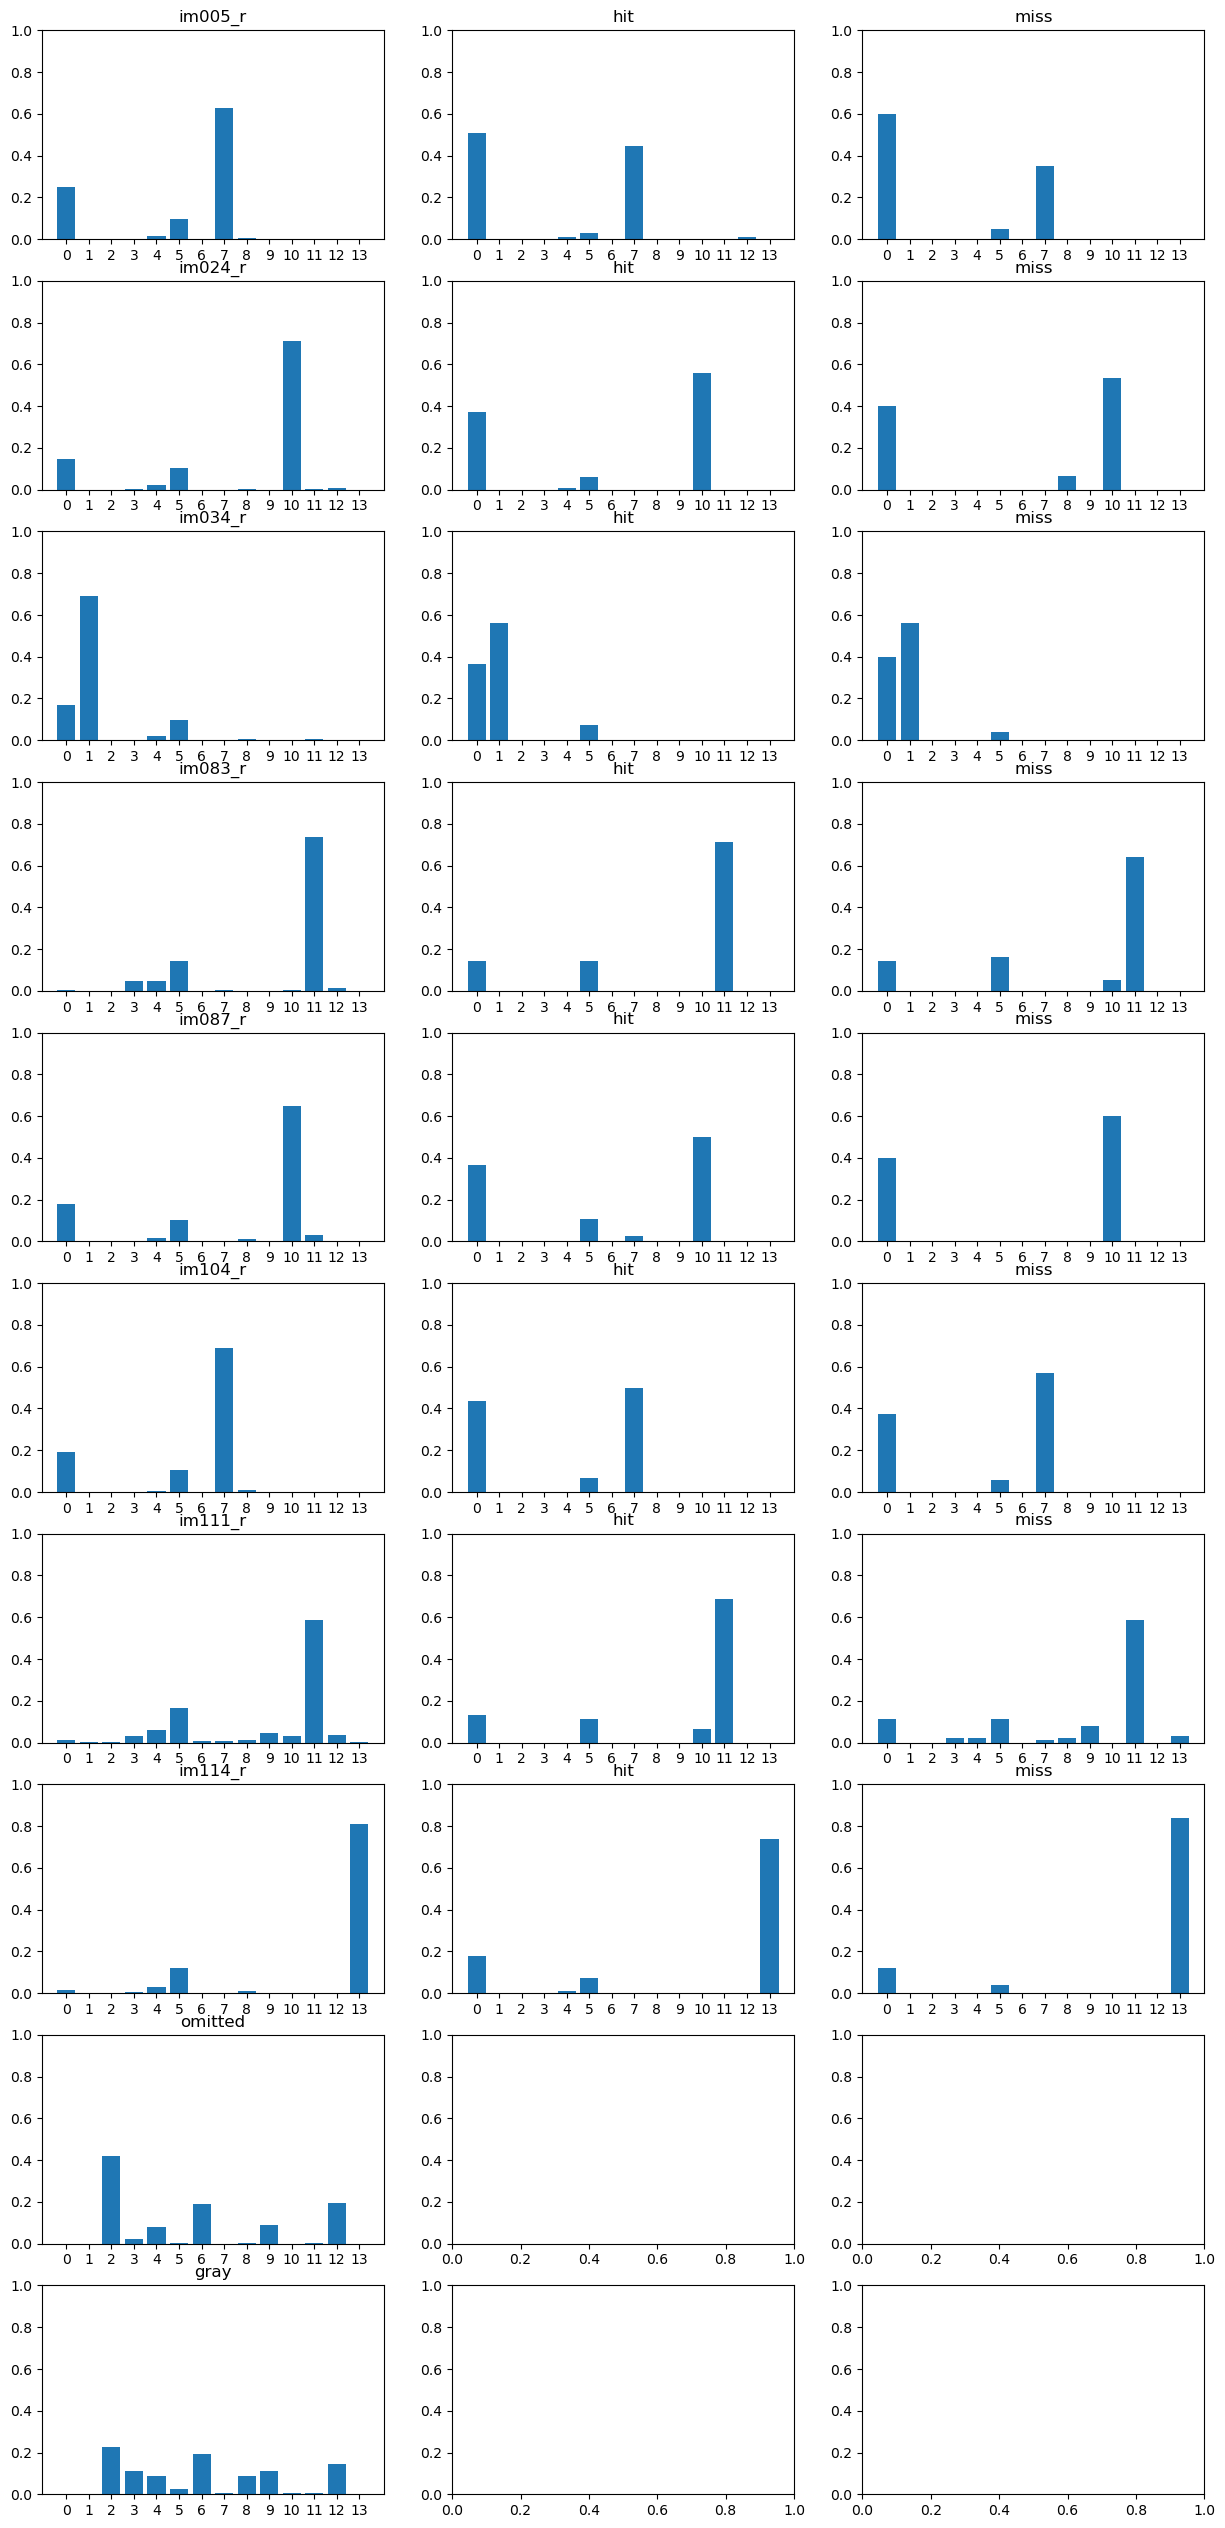

In [445]:
stimulus_state_dist(unchanged, hit, miss, gray)

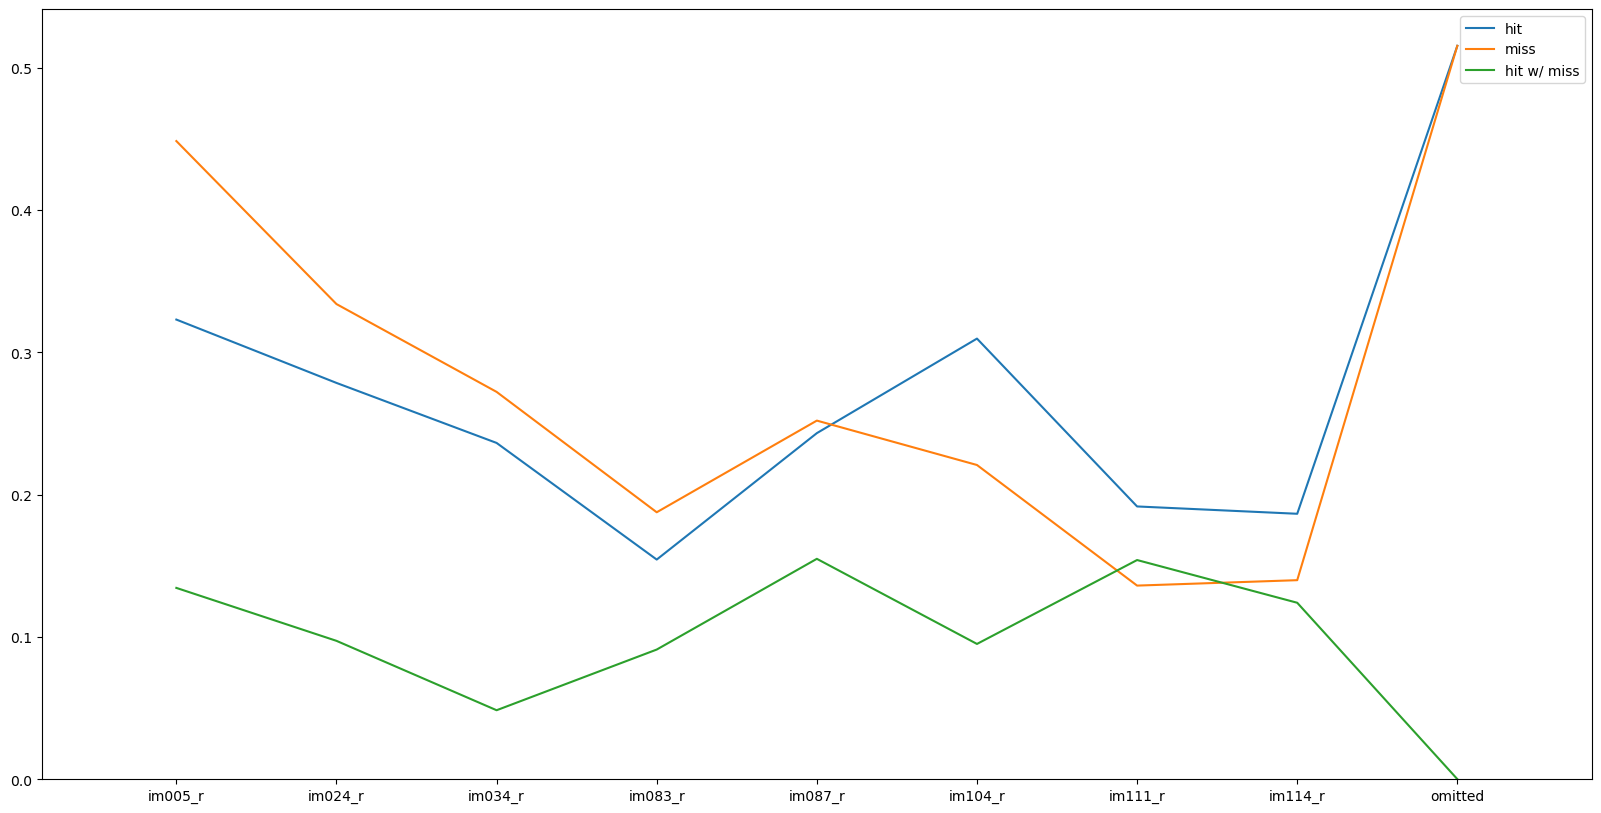

In [450]:
stimulus_state_diff(unchanged, hit, miss, gray)

### Compare Hidden State Distribution for each Image in different runs

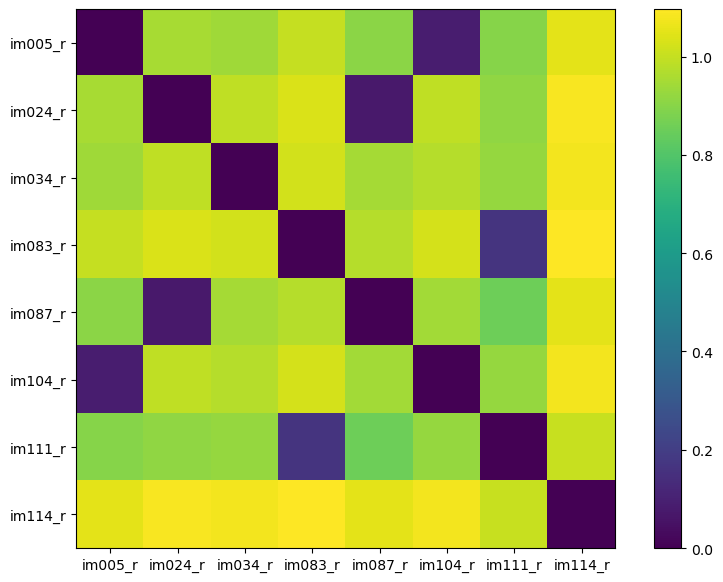

In [430]:
# unchanged
imgs = list(unchanged.keys())[0:-1]
diff = np.zeros([len(imgs), len(imgs)])
for idx, img in enumerate(imgs):
    for jdx, img_2 in enumerate(imgs):
        img1 = np.array(list(unchanged[img].values()))
        img1 = img1 / np.sum(img1)
        img2 = np.array(list(unchanged[img_2].values()))
        img2 = img2 / np.sum(img2)
        diff[idx][jdx] = np.linalg.norm(img1-img2)
plt.figure(figsize=(10,7))
plt.imshow(diff)
plt.colorbar()
plt.yticks(ticks = np.arange(0,8), labels = imgs);
plt.xticks(ticks = np.arange(0,8), labels = imgs);

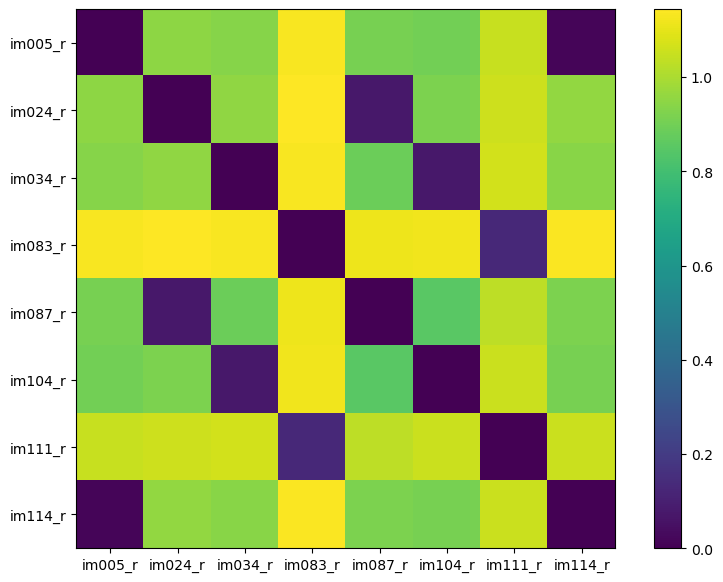

In [ ]:
# hit
imgs = list(hit.keys())[0:-1]
diff = np.zeros([len(imgs), len(imgs)])
for idx, img in enumerate(imgs):
    for jdx, img_2 in enumerate(imgs):
        img1 = np.array(list(hit[img].values()))
        img1 = img1 / np.sum(img1)
        img2 = np.array(list(hit[img_2].values()))
        img2 = img2 / np.sum(img2)
        diff[idx][jdx] = np.linalg.norm(img1-img2)
plt.figure(figsize=(10,7))
plt.imshow(diff)
plt.colorbar()
plt.yticks(ticks = np.arange(0,8), labels = imgs);
plt.xticks(ticks = np.arange(0,8), labels = imgs);

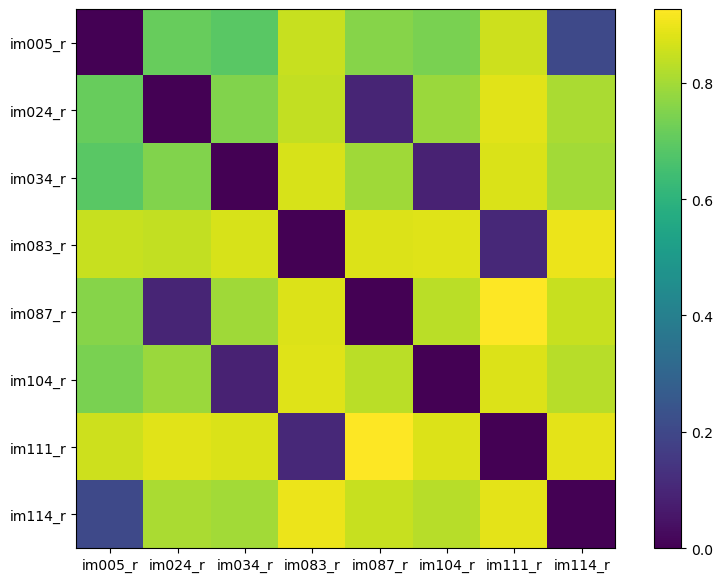

In [268]:
# unchanged
imgs = list(miss.keys())[0:-1]
diff = np.zeros([len(imgs), len(imgs)])
for idx, img in enumerate(imgs):
    for jdx, img_2 in enumerate(imgs):
        img1 = np.array(list(miss[img].values()))
        img1 = img1 / np.sum(img1)
        img2 = np.array(list(miss[img_2].values()))
        img2 = img2 / np.sum(img2)
        diff[idx][jdx] = np.linalg.norm(img1-img2)
plt.figure(figsize=(10,7))
plt.imshow(diff)
plt.colorbar()
plt.yticks(ticks = np.arange(0,8), labels = imgs);
plt.xticks(ticks = np.arange(0,8), labels = imgs);

c:\Users\Jerry\anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Jerry\anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


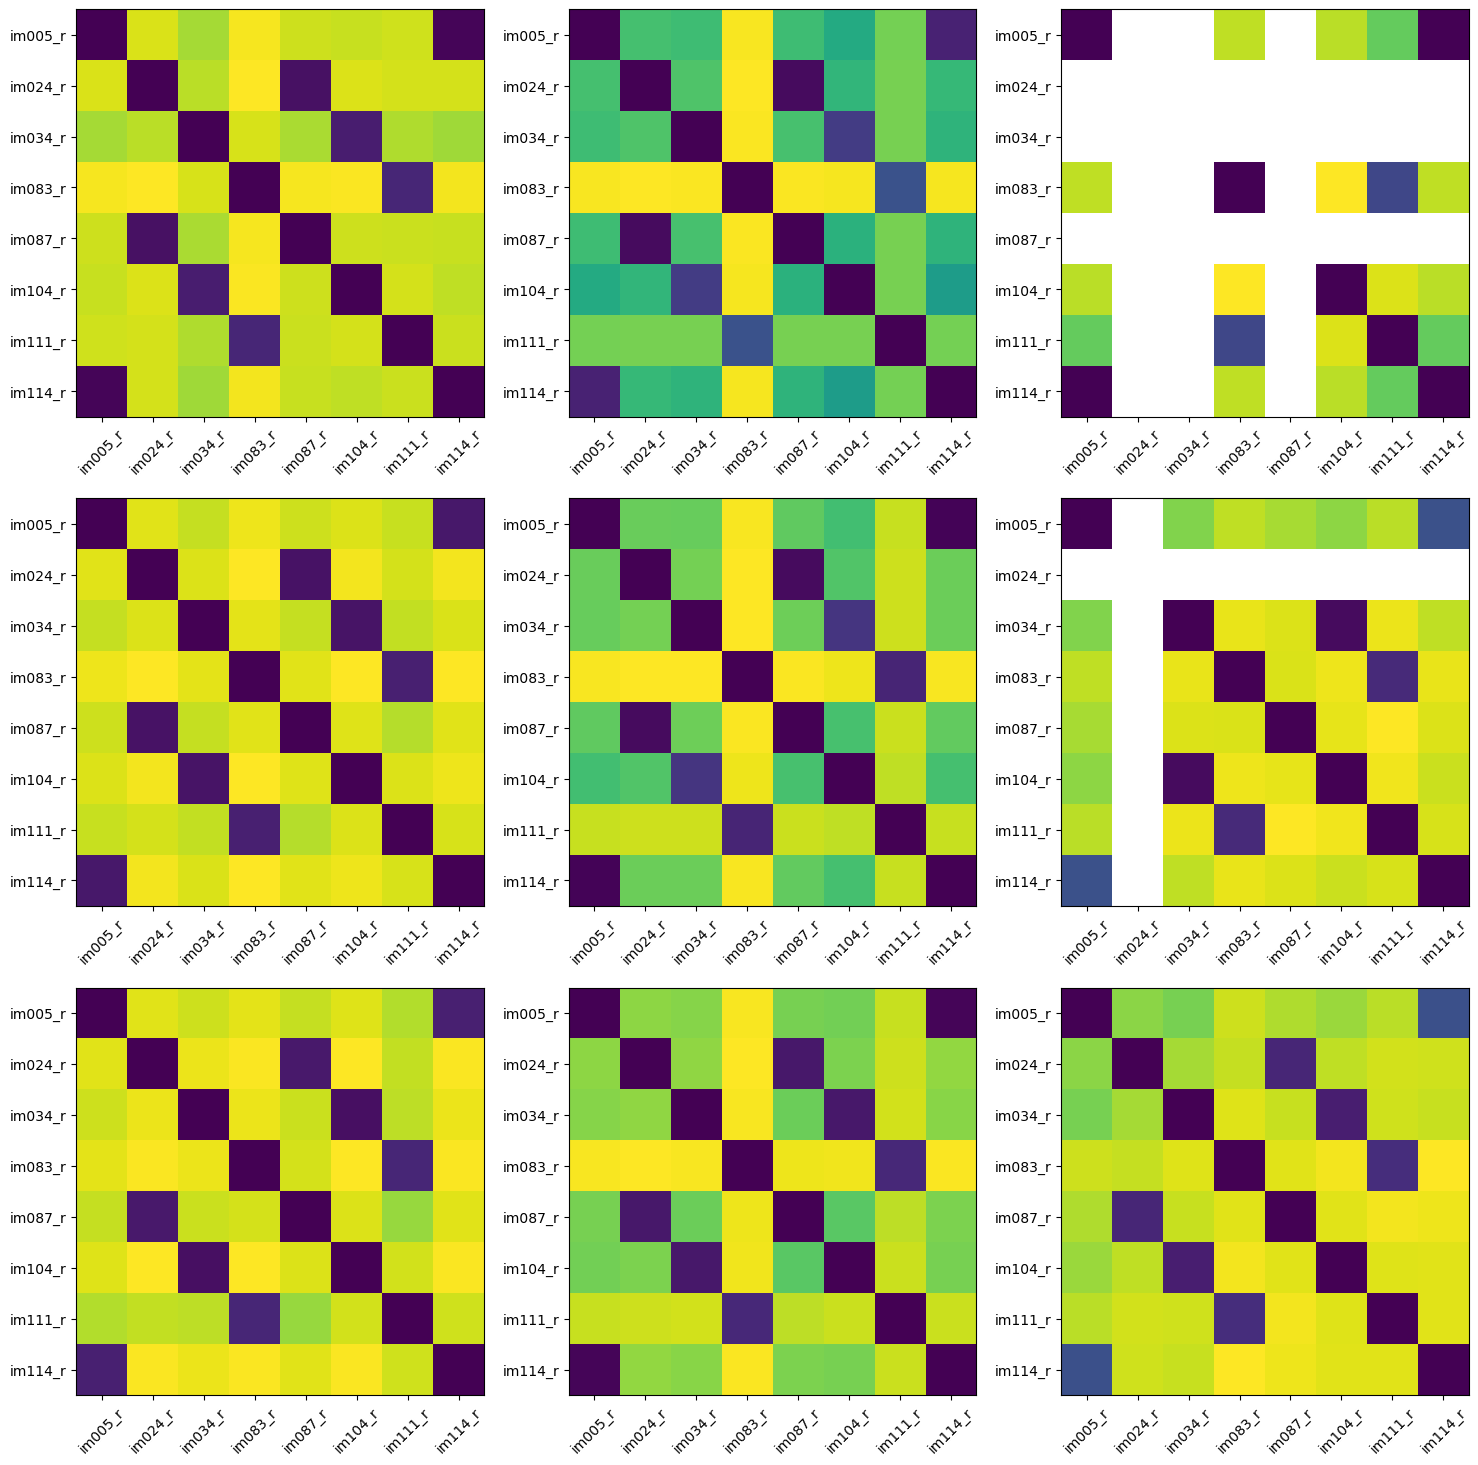

In [176]:
n = 3
fig, ax = plt.subplots(n, 3 ,figsize=(18,18))
lower_bound = 0
upper_bound = 0
frac = int(1/n * len(preds))
for idx in range(n):
    lower_bound = 0 # Continue from the last upper bound
    lower_time = start_time + lower_bound * bin_size / 1000
    upper_bound = (idx + 1) * frac
    upper_time = start_time + upper_bound * bin_size / 1000
    preds_sub = preds[lower_bound:upper_bound]
    unchanged, hit, miss, gray = states_per_img_no_first(lower_time, upper_time, bin_size, preds_sub)
    imgs = list(unchanged.keys())[0:-1]
    u = np.zeros([len(imgs), len(imgs)])
    h = np.zeros([len(imgs), len(imgs)])
    m = np.zeros([len(imgs), len(imgs)])
    for kdx, img in enumerate(imgs):
        for jdx, img_2 in enumerate(imgs):
            u_1 = np.array(list(unchanged[img].values()))
            u_1 = u_1 / np.sum(u_1)
            u_2 = np.array(list(unchanged[img_2].values()))
            u_2 = u_2 / np.sum(u_2)
            h_1 = np.array(list(hit[img].values()))
            h_1 = h_1 / np.sum(h_1)
            h_2 = np.array(list(hit[img_2].values()))
            h_2 = h_2 / np.sum(h_2)
            m_1 = np.array(list(miss[img].values()))
            m_1 = m_1 / np.sum(m_1)
            m_2 = np.array(list(miss[img_2].values()))
            m_2 = m_2 / np.sum(m_2)
            u[kdx][jdx] = np.linalg.norm(u_1-u_2)
            h[kdx][jdx] = np.linalg.norm(h_1-h_2)
            m[kdx][jdx] = np.linalg.norm(m_1-m_2)
    #plt.figure(figsize=(10,7))
    ax[idx][0].imshow(u)
    ax[idx][1].imshow(h)
    ax[idx][2].imshow(m)
    ax[idx][0].set_xticks(np.arange(len(imgs)))
    ax[idx][0].set_xticklabels(imgs, rotation=45)
    ax[idx][0].set_yticks(np.arange(len(imgs)))
    ax[idx][0].set_yticklabels(imgs)
    ax[idx][1].set_xticks(np.arange(len(imgs)))
    ax[idx][1].set_xticklabels(imgs, rotation=45)
    ax[idx][1].set_yticks(np.arange(len(imgs)))
    ax[idx][1].set_yticklabels(imgs)
    ax[idx][2].set_xticks(np.arange(len(imgs)))
    ax[idx][2].set_xticklabels(imgs, rotation=45)
    ax[idx][2].set_yticks(np.arange(len(imgs)))
    ax[idx][2].set_yticklabels(imgs)

In [281]:
arr = ['a','b','c', 'd']
try:
    arr.remove('d')
except:
    print("No Omitted")
print(arr)

['a', 'b', 'c']


In [287]:

print(scores)

['im005_r', 'im024_r', 'im034_r', 'im083_r', 'im087_r', 'im104_r', 'im111_r', 'im114_r']


ValueError: setting an array element with a sequence.

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=50, n_jobs=-1).fit_transform(X_train)

In [ ]:
# Getting the lambdas and apply tSNE to them 

### MSE and SSIM Image Comparisons

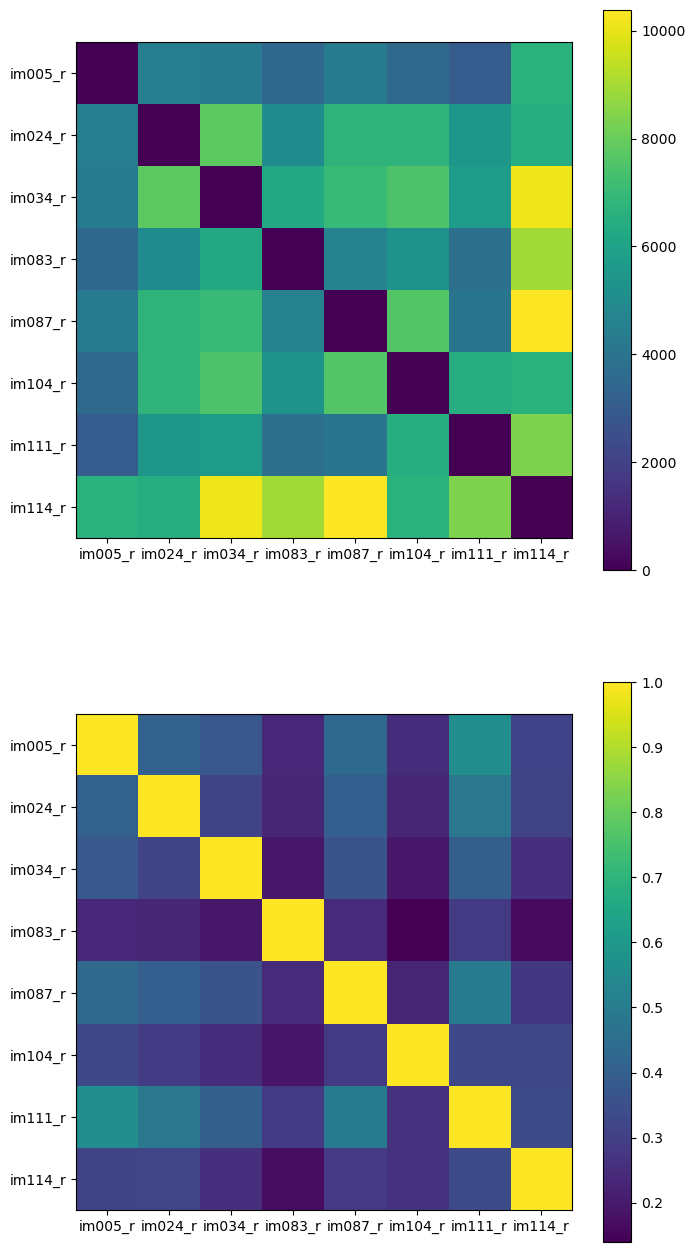

In [256]:
fig, ax = plt.subplots(2,figsize=(8,16))
imgs = list(behavior.stimulus_templates.warped.keys())
imgs.sort()

mse_scores = np.zeros((len(imgs),len(imgs)))
ssim_scores = np.zeros((len(imgs),len(imgs)))
for idx, img in enumerate(imgs):
    for jdx, img2 in enumerate(imgs):
        img_1 = behavior.stimulus_templates.warped[img]
        img_2 = behavior.stimulus_templates.warped[img2]
        mse_scores[idx][jdx] = mean_squared_error(img_1, img_2)
        ssim_scores[idx][jdx] = ssim(img_1, img_2, data_range=img_2.max() - img_2.min())

img1 = ax[0].imshow(mse_scores);
ax[0].set_xticks(ticks=np.arange(0,8));
ax[0].set_xticklabels(imgs)
ax[0].set_yticks(ticks=np.arange(0,8));
ax[0].set_yticklabels(imgs)
fig.colorbar(img1, ax=ax[0]);
img2 = ax[1].imshow(ssim_scores)
ax[1].set_xticks(ticks=np.arange(0,8));
ax[1].set_xticklabels(imgs)
ax[1].set_yticks(ticks=np.arange(0,8));
ax[1].set_yticklabels(imgs)
fig.colorbar(img2, ax=ax[1]);

### Preparing data for rastermap

In [ ]:
start_time = 0
end_time = 3000
bin_size = 50
#spks
X_train = getX(start_time,end_time,bin_size)
#run
running_speed = session.running_speed
timestamp_end = np.where(running_speed['timestamps'] > end_time)[0][0]
timestamps = running_speed['timestamps'][:timestamp_end]
speed = running_speed['speed'][0:timestamp_end]
interp = np.arange(25.50, end_time, bin_size/1000)
padding = np.zeros(len(np.arange(0,25.50,bin_size/1000)))
run = np.interp(interp, timestamps, speed)
run = np.concatenate((padding, run))
#lick
licks = np.array(session.licks['timestamps'])
stop_idx = np.where(licks > end_time)[0][0]
licks = licks[:stop_idx]
licks = licks / (bin_size / 1000)
#store
data = {'run':run, 'spks': X_train, 'licks':licks}
path = "E:/jerry/vbn_s3_cache/visual-behavior-neuropixels-0.5.0/behavior_ecephys_sessions/1064644573/1064644573_0_3000_50_all.npy"
np.save(path, data, allow_pickle=True)

100%|████████████████████████████████████████████████████████████████████████████████| 271/271 [00:07<00:00, 35.59it/s]
